In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks

BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NUM_CLASSES = 2


In [ ]:
TRAIN_PATH = '../content/drive/MyDrive/DFU/Patches'
TEST_PATH = '../content/drive/MyDrive/DFU/TestSet'


(224, 224, 3)


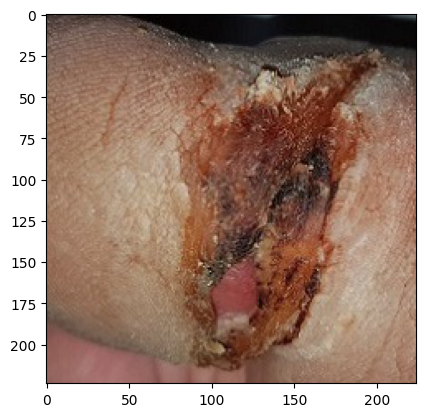

In [ ]:
fpath='../content/drive/MyDrive/DFU/Patches/Abnormal(Ulcer)/10.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [ ]:
# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'validation',
    seed = 0
)

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


In [ ]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(TEST_PATH + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)']


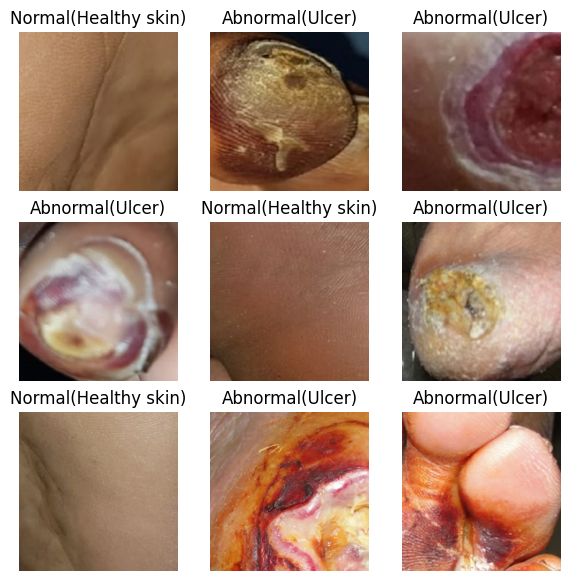

In [ ]:

# Visualize the training dataset
plt.figure(figsize = (7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

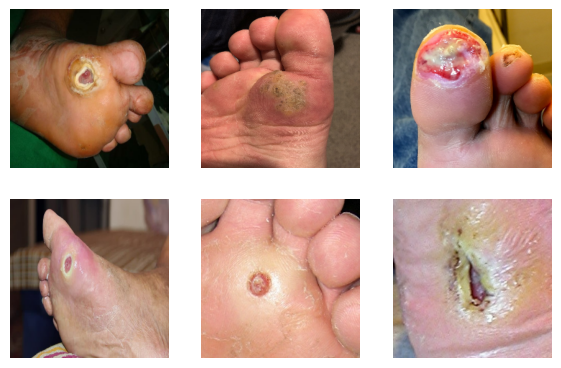

In [ ]:

# Visualize the testing dataset
plt.figure(figsize = (7, 7))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

In [ ]:

# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

In [ ]:

# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:

# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)

In [ ]:

# Initialize Model
def build_model():
    inputs = layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = img_augmentation(inputs)

    model = EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor = x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.45
    x = layers.Dropout(top_dropout_rate, seed=123, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "sigmoid", name = "pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=1e-3)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy"]
    )

    model.summary()

    return model

In [ ]:

model = build_model()

43941136/43941136 [==============================] - 2s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization (Normal

In [ ]:
history = model.fit(train_ds, validation_data = validation_ds,
                    callbacks = [lr_callback, stop_callback],
                    epochs = 20)

Epoch 1/20
27/27 [==============================] - 17s 629ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0075 - val_accuracy: 0.9953 - lr: 1.0000e-04
Epoch 2/20
27/27 [==============================] - 17s 633ms/step - loss: 0.0129 - accuracy: 0.9953 - val_loss: 0.0076 - val_accuracy: 0.9953 - lr: 1.0000e-04
Epoch 3/20
27/27 [==============================] - 17s 635ms/step - loss: 0.0093 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/20
27/27 [==============================] - 17s 638ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.0052 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
27/27 [==============================] - 17s 644ms/step - loss: 0.0098 - accuracy: 0.9964 - val_loss: 0.0054 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/20
27/27 [==============================] - 18s 661ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/20
27/27 [======================

1/1 [==============================] - 0s 62ms/step


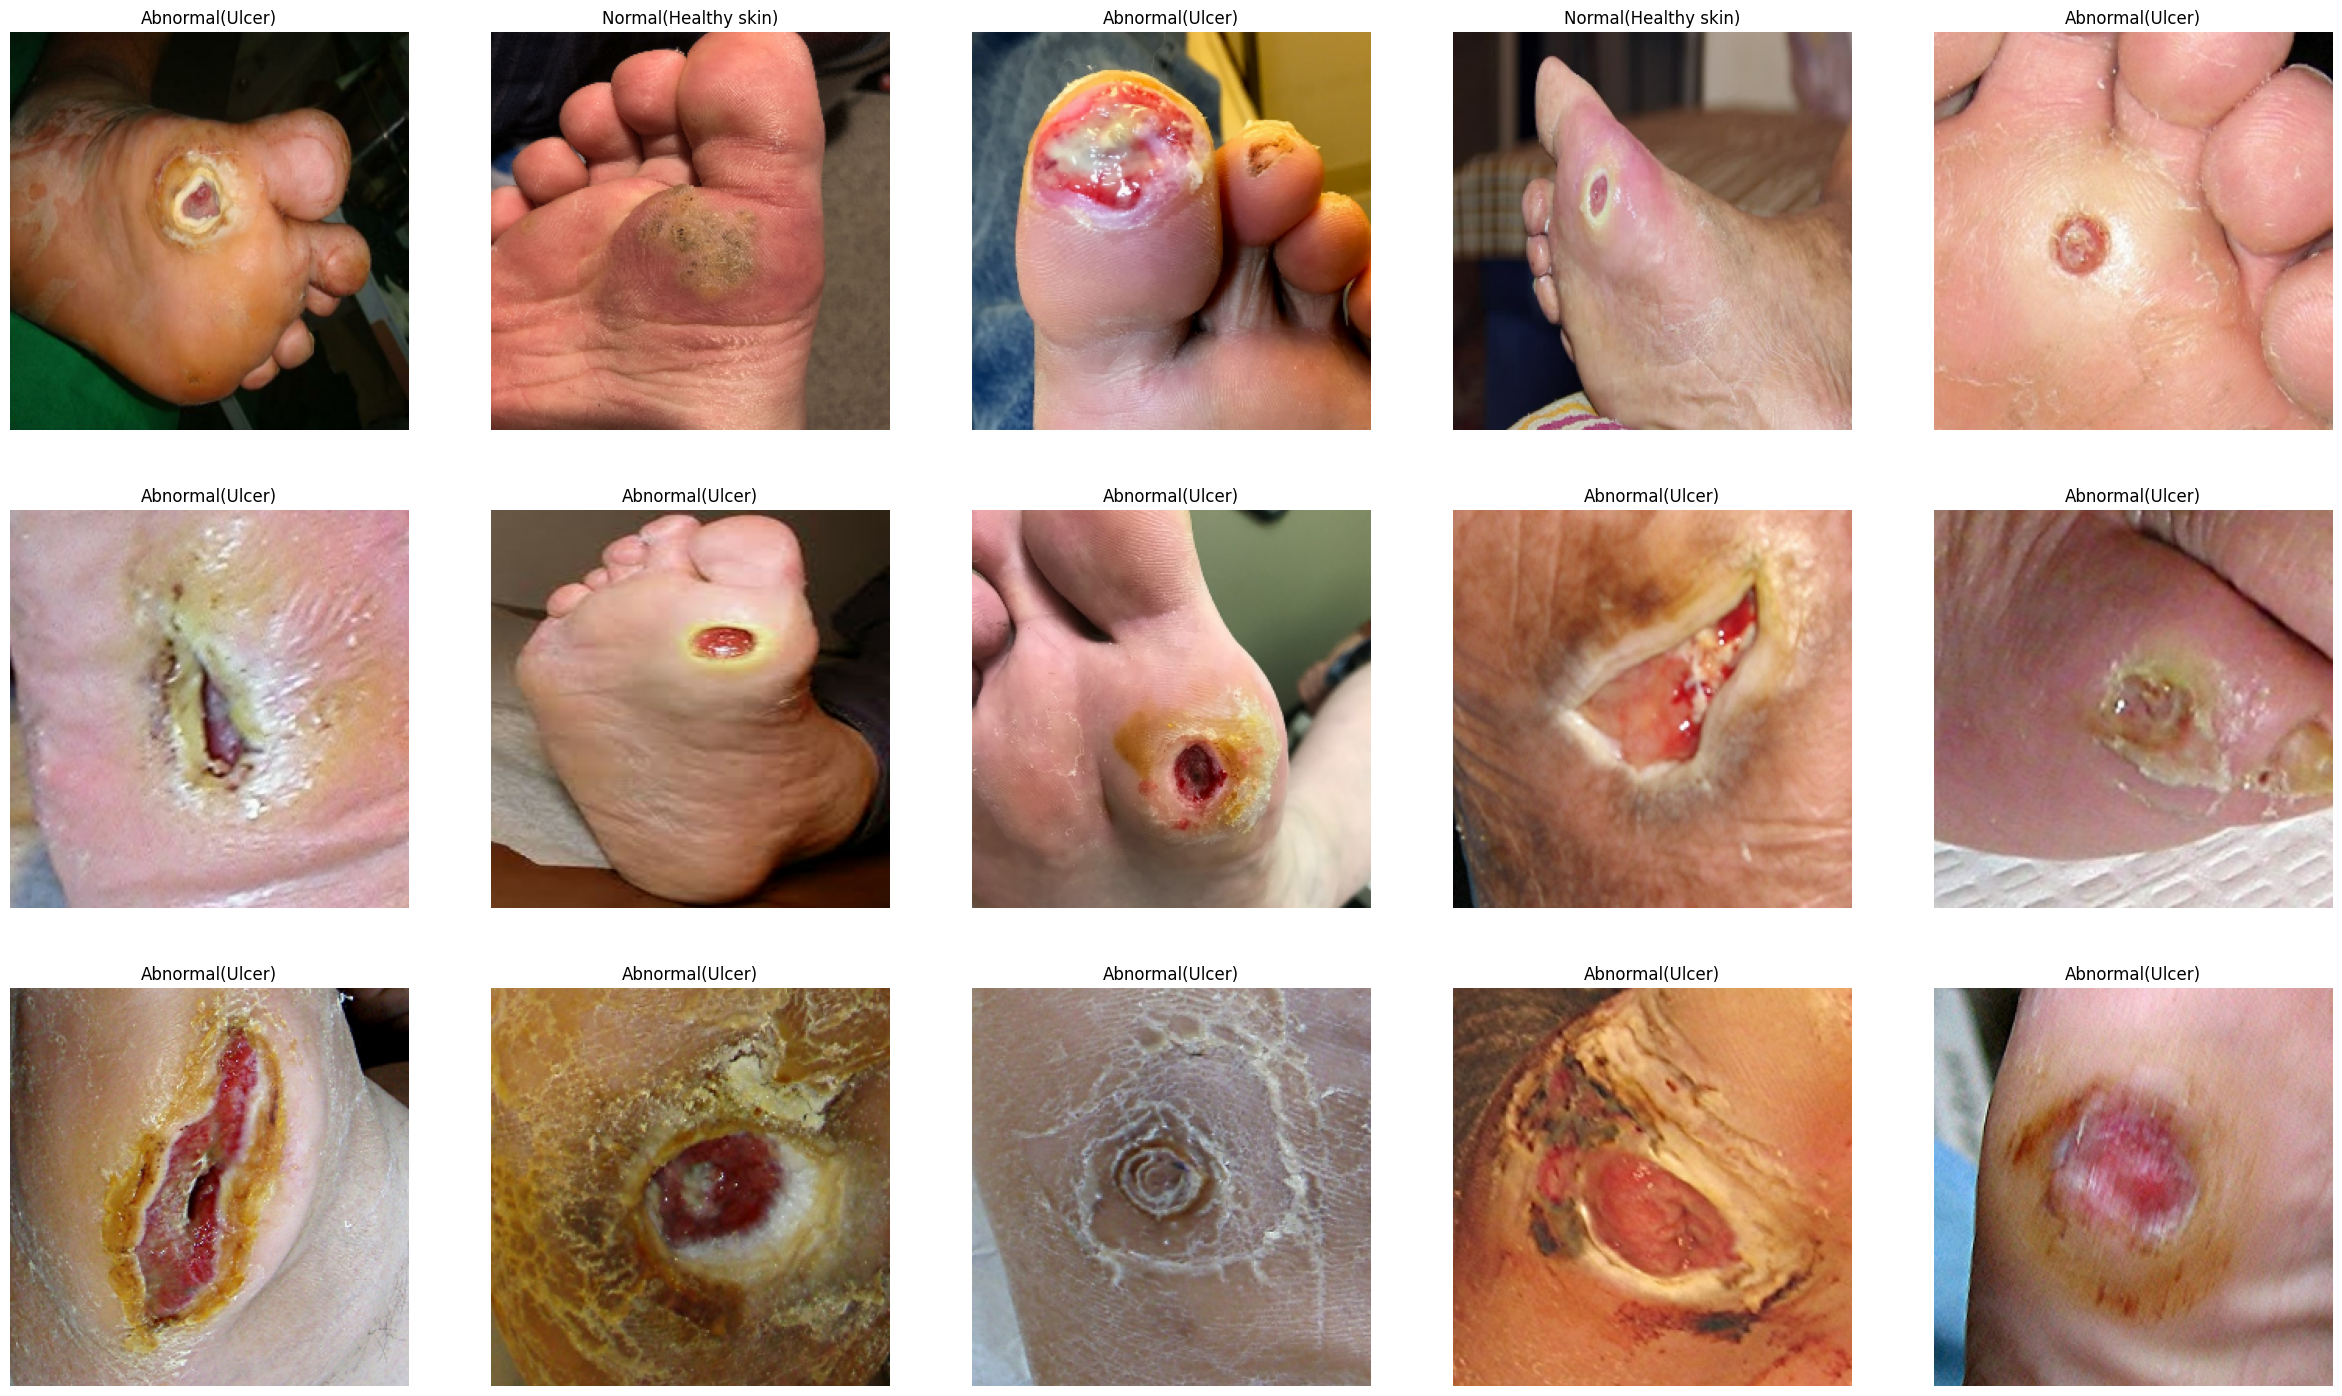

In [ ]:

# Testing on Test Set
plt.figure(figsize = (30, 30))
plt.tight_layout()

i = 0
for images in test_ds.take(15):
    ax = plt.subplot(5, 5, i + 1)
    prediction = np.argmax(model.predict(np.array([images])), axis = 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[prediction[0]])
    plt.axis("off")

    i += 1

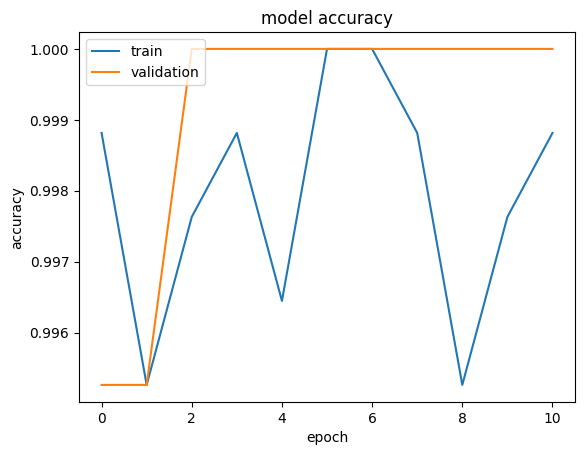

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Convert the SavedModel to TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
# tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)